In [1]:
import pandas as pd
import scipy
import numpy as np
import scipy.sparse as sp
import scipy.io as spio

import operator
import matplotlib.pyplot as plt
import regex as re

def plot_cut_2mers(datafr, cut_mat) :
    cut_mer2 = {}

    seqs = list(datafr['seq'].values)
    seqs = np.array(seqs, dtype=np.object)

    total_count = np.array(datafr['total_count'])

    cx = sp.coo_matrix(cut_mat)

    for i,j,v in zip(cx.row, cx.col, cx.data) :
        seq = seqs[i]

        mer2 = seq[j-1:j+1]
        if mer2 not in cut_mer2 :
            cut_mer2[mer2] = 0
        cut_mer2[mer2] += v

    cut_mer2_sorted = sorted(cut_mer2.items(), key=operator.itemgetter(1))

    mer2_list = []
    mer2_vals = []
    for i in range(0, len(cut_mer2_sorted)) :
        mer2_list.append(cut_mer2_sorted[i][0])
        mer2_vals.append(cut_mer2_sorted[i][1])

    f = plt.figure(figsize=(6, 4))

    plt.bar(mer2_list, mer2_vals, color='black')

    plt.title('Proximal cleavage dinuc.', fontsize=14)
    plt.xlabel('Dinucleotide', fontsize=14)
    plt.ylabel('Read count', fontsize=14)

    plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()

In [2]:
library_name = 'tomm5'
library_version = 'unfiltered'

cut_matrix_name = 'proximal_cut'#'proximal_cut_prefixed'#

In [3]:
raw_data_name = 'tomm5_readmatch_hamming1_umimatch_hamming1'
data = pd.read_csv(raw_data_name + '.csv', sep=',').reset_index(drop=True)

In [4]:
emitted_proximal_count = []
emitted_distal_count = []
emitted_total_count = []
emitted_seq = []
emitted_mask = []
emitted_lib = []
emitted_lib_index = []
emitted_sublib = []
emitted_sublib_index = []

proximal_cuts = sp.lil_matrix((len(data), 206)) #PAS CSE starts at 60

up_constant = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXAATGATACGGCGACCACCGAGATCTACACACACTCTTTCCCTACACGACGCTCTTCCGATCTXXXXXXXXXXXXGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGGACTGATAGTAAGGCCCATTACCTGCGGCCGCAATTCTGCT'
dn_constant = 'ACCCTTATCCCTGTGACGTTTGGCCTCTGACAATACTGGTATAATTGTAAATAATGTCAAACTCCGTTTTCTAGCAAGTATTAAGGGAGCTGTGTCTGAAATGGCACTGTCTTGTCAGTCATTTGCGGCCGCCTGTTTACCTTTTTCTTCTGCCCAGAGTGTATTTGTGAAGAGTCTCTTATATTATGTTTTGTGGAAATCAGCACACAACCACAATGACATTTAAGCACAGGATCATTATTAGTCTATGTTTTTAATAAACATATCAATTAAGAAAAAAAAAAAAAAAAAAAAGATCGG'

up_constant_dataframe = up_constant[-24:]
up_constant_metadata = up_constant[-24 - 190:-24]

dn_constant_dataframe = dn_constant[:89]
dn_constant_metadata = dn_constant[89:89 + 120]

In [5]:
lib_up_variant_a = re.compile(r"([ACGTN]{20}CTGGTAACTGACCTTCAAAG){s<=3}")
lib_up_variant_b = re.compile(r"(TGTTAAGAAC[ACGTN]{20}ACCTTCAAAG){s<=3}")
lib_up_variant_c = re.compile(r"(TGTTAAGAACAAGTTTGGCT[ACGTN]{20}){s<=3}")
lib_up_variant_d = re.compile(r"(TGTTAAGAAC[ACGTN]{10}CTGGTAACTGACCTTCAAAG){s<=1}")
lib_up_variant_e = re.compile(r"(TGTTAAGAACAAGTT[ACGTN]{10}AACTGACCTTCAAAG){s<=1}")
lib_up_variant_f = re.compile(r"(TGTTAAGAACAAGTTTGGCT[ACGTN]{10}ACCTTCAAAG){s<=1}")

lib_dn_variant_a = re.compile(r"(GATGTCTCGTGATCTGGTGT){s<=1}")
lib_dn_variant_b = re.compile(r"....................")


libs = [
    ['tomm5_up_c15n10c15_dn_c20', lib_up_variant_e, lib_dn_variant_a, [[15, 25], [0, 0]], [], [], [], []],
    ['tomm5_up_c10n10c20_dn_c20', lib_up_variant_d, lib_dn_variant_a, [[10, 20], [0, 0]], [], [], [], []],
    ['tomm5_up_n20c20_dn_c20', lib_up_variant_a, lib_dn_variant_a, [[0, 20], [0, 0]], [], [], [], []],
    ['tomm5_up_c20n10c10_dn_c20', lib_up_variant_f, lib_dn_variant_a, [[20, 30], [0, 0]], [], [], [], []],
    ['tomm5_up_c10n20c10_dn_c20', lib_up_variant_b, lib_dn_variant_a, [[10, 30], [0, 0]], [], [], [], []],
    ['tomm5_up_c20n20_dn_c20', lib_up_variant_c, lib_dn_variant_a, [[20, 40], [0, 0]], [], [], [], []],
    ['tomm5_up_c15n10c15_dn_n20', lib_up_variant_e, lib_dn_variant_b, [[15, 25], [0, 20]], [], [], [], []],
    ['tomm5_up_c10n10c20_dn_n20', lib_up_variant_d, lib_dn_variant_b, [[10, 20], [0, 20]], [], [], [], []],
    ['tomm5_up_n20c20_dn_n20', lib_up_variant_a, lib_dn_variant_b, [[0, 20], [0, 20]], [], [], [], []],
    ['tomm5_up_c20n10c10_dn_n20', lib_up_variant_f, lib_dn_variant_b, [[20, 30], [0, 20]], [], [], [], []],
    ['tomm5_up_c10n20c10_dn_n20', lib_up_variant_b, lib_dn_variant_b, [[10, 30], [0, 20]], [], [], [], []],
    ['tomm5_up_c20n20_dn_n20', lib_up_variant_c, lib_dn_variant_b, [[20, 40], [0, 20]], [], [], [], []]
]

In [6]:

#Store library meta data

df_metadata = pd.DataFrame(
    {
        'library' : [lib[0] for lib in libs],
        'library_index' : [i for i in range(len(libs))],
        'sublibrary' : [lib[0] for lib in libs],
        'sublibrary_index' : [i for i in range(len(libs))],
        'upstream_padding' : [up_constant_metadata for i in range(len(libs))],
        'downstream_padding' : [dn_constant_metadata for i in range(len(libs))]
    }
)

df_metadata = df_metadata[['library', 'library_index', 'sublibrary', 'sublibrary_index', 'upstream_padding', 'downstream_padding']]

df_metadata.to_csv(library_name + '_metadata.csv', header=True, index=False, sep=',')


In [7]:
move_cut_to_non_a = True

for index, row in data.iterrows() :
    if index % 100000 == 0:
        print("Read up to sequence: " + str(index))

    upstream_seq = row['upstream']
    downstream_seq = row['downstream']
    pas_seq = row['pas']

    seq = row['seq']
    
    lib_index = -1
    lib = ''
    up_index = [0, 40]
    dn_index = [0, 20]
    for j in range(0, len(libs)) :
        up_regex = libs[j][1]
        dn_regex = libs[j][2]

        if re.search(up_regex, upstream_seq) and re.search(dn_regex, downstream_seq) :
            lib_index = j
            lib = libs[j][0]
            
            up_index[0] = libs[j][3][0][0]
            up_index[1] = libs[j][3][0][1]
            dn_index[0] = libs[j][3][1][0]
            dn_index[1] = libs[j][3][1][1]
            
            break
    
    mask = ('X' * (up_index[0])) + ('N' * (up_index[1] - up_index[0])) + ('X' * (40 - up_index[1]))
    mask += ('X' * 33)
    mask += ('X' * (dn_index[0])) + ('N' * (dn_index[1] - dn_index[0])) + ('X' * (20 - dn_index[1]))

    cut_str = row[cut_matrix_name]
    cut_str = cut_str[1:len(cut_str)-1]
    cuts_member = cut_str.split(', ')
    
    proximal_count = 0
    
    if cut_str != '' :
        for j in range(0, len(cuts_member)) :
            cutpos = int(cuts_member[j]) + 24
            
            if move_cut_to_non_a :
                jj_char = 0
                while (up_constant_dataframe + seq)[cutpos-1] == 'A' and cutpos > 0 and jj_char < 2 :
                    cutpos -= 1
                    jj_char += 1

            proximal_cuts[index, cutpos] += 1

            proximal_count += 1
    
    distal_count = row['distal_count']
    total_count = proximal_count + distal_count

    #Sequence length 196
    emitted_seq.append(up_constant_dataframe + seq + dn_constant_dataframe)
    emitted_mask.append(('X' * len(up_constant_dataframe)) + mask + ('X' * len(dn_constant_dataframe)))
    
    emitted_lib.append(lib)
    emitted_lib_index.append(lib_index)
    emitted_sublib.append(lib)
    emitted_sublib_index.append(lib_index)

    emitted_proximal_count.append(proximal_count)
    emitted_distal_count.append(distal_count)
    emitted_total_count.append(total_count)

Read up to sequence: 0
Read up to sequence: 100000
Read up to sequence: 200000
Read up to sequence: 300000
Read up to sequence: 400000
Read up to sequence: 500000
Read up to sequence: 600000
Read up to sequence: 700000
Read up to sequence: 800000


In [8]:

#Inflate dataframe

df = pd.DataFrame({'seq'  : emitted_seq,
                    'mask'  : emitted_mask,
                    'proximal_count'  : emitted_proximal_count,
                    'distal_count'  : emitted_distal_count,
                    'total_count'  : emitted_total_count,
                    'library'  : emitted_lib,
                    'library_index'  : emitted_lib_index,
                    'sublibrary'  : emitted_sublib,
                    'sublibrary_index'  : emitted_sublib_index
                })


In [9]:

#Simultaneously sort dataframe and cut matrices

total_count = np.array(df['total_count'])
sort_index = np.argsort(total_count)

df = df.iloc[sort_index].reset_index(drop=True)
proximal_cuts = proximal_cuts[sort_index]


In [10]:

#Store dataframe and cut matrices

df = df[['seq', 'mask', 'proximal_count', 'distal_count', 'total_count', 'library', 'library_index', 'sublibrary', 'sublibrary_index']]

df.to_csv(library_name + '_' + library_version + '.csv', header=True, index=False, sep=',')

spio.savemat(library_name + '_' + library_version + '_cuts', {'cuts' : proximal_cuts})


In [11]:

#Read dataframe and cut matrices

df = pd.read_csv(library_name + '_' + library_version + '.csv', delimiter=',').reset_index(drop=True)

proximal_cuts = spio.loadmat(library_name + '_' + library_version + '_cuts.mat')['cuts']

print(len(df))


819644


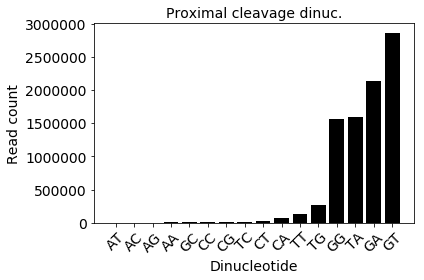

In [12]:
plot_cut_2mers(df, proximal_cuts) #Add code to remove AA cutsite

In [13]:
import regex as re

#Filter dataframe and cut matrices

dse_misprime_regex = re.compile(r"(AAAAAAAA){s<=2}")

misprime_regexes = [
    re.compile(r"(AAAAAAAAAAA){s<=2}"),
    re.compile(r"(AAAAAAAAAAAAAAAA){s<=4}"),
    re.compile(r"(AAAAAAAAAAAAAAAAAAAA){s<=5}")
]

keep_index = []
for index, row in df.iterrows() :
    if index % 100000 == 0:
        print("Read up to sequence: " + str(index))
    
    curr_seq_unfilt = row['seq']
    curr_mask = row['mask']
    
    curr_seq = ''
    for j in range(0, len(curr_seq_unfilt)) :
        if curr_mask[j] == 'N' :
            curr_seq += curr_seq_unfilt[j]
        else :
            curr_seq += 'X'
    
    internal_priming = False
    for misprime_regex in misprime_regexes :
        if re.search(misprime_regex, curr_seq) :
            internal_priming = True
            break
    
    if re.search(dse_misprime_regex, curr_seq[75:]) :
        internal_priming = True
    
    if not internal_priming :
        keep_index.append(index)


df_cleaned = df.iloc[keep_index].reset_index(drop=True)

proximal_cuts_cleaned = proximal_cuts[keep_index]

print(len(df_cleaned))
print(proximal_cuts_cleaned.shape[0])


Read up to sequence: 0
Read up to sequence: 100000
Read up to sequence: 200000
Read up to sequence: 300000
Read up to sequence: 400000
Read up to sequence: 500000
Read up to sequence: 600000
Read up to sequence: 700000
Read up to sequence: 800000
799341
799341


In [14]:
#Store dataframe and cut matrices
library_version = 'cleaned'

df_cleaned = df_cleaned[['seq', 'mask', 'proximal_count', 'distal_count', 'total_count', 'library', 'library_index', 'sublibrary', 'sublibrary_index']]

df_cleaned.to_csv(library_name + '_' + library_version + '.csv', header=True, index=False, sep=',')

spio.savemat(library_name + '_' + library_version + '_cuts', {'cuts' : proximal_cuts_cleaned})

In [15]:
#Read dataframe and cut matrices
library_version = 'cleaned'

df_cleaned = pd.read_csv(library_name + '_' + library_version + '.csv', delimiter=',').reset_index(drop=True)

proximal_cuts_cleaned = spio.loadmat(library_name + '_' + library_version + '_cuts.mat')['cuts']

print(len(df_cleaned))

799341


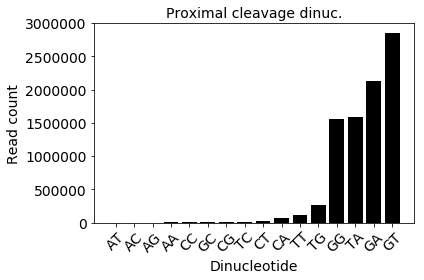

In [16]:
plot_cut_2mers(df_cleaned, proximal_cuts_cleaned)

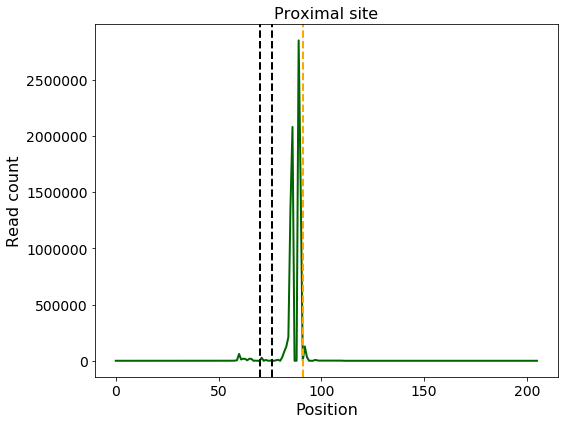

In [17]:

proximal_profile = np.ravel(proximal_cuts_cleaned.sum(axis=0))

f = plt.figure(figsize=(8, 6))

plt.plot(np.arange(len(proximal_profile)), proximal_profile, c='darkgreen', linewidth=2)

#Proximal 1
plt.axvline(x=70, linewidth=2, c='black', linestyle='--')
plt.axvline(x=70 + 6, linewidth=2, c='black', linestyle='--')
plt.axvline(x=70 + 21, linewidth=2, c='orange', linestyle='--')


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Position', fontsize=16)
plt.ylabel('Read count', fontsize=16)
plt.title('Proximal site', fontsize=16)
plt.tight_layout()

plt.show()


In [18]:

#Filter final version on read count

total_count = np.array(df_cleaned['total_count'])
filter_index = np.nonzero(total_count >= 10)[0]

df_final = df_cleaned.iloc[filter_index].reset_index(drop=True)
proximal_cuts_final = proximal_cuts_cleaned[filter_index]

print(len(df_final))
print(proximal_cuts_final.shape[0])


712949
712949


In [19]:
#Store dataframe and cut matrices
library_version = 'final'

df_final = df_final[['seq', 'mask', 'proximal_count', 'distal_count', 'total_count', 'library', 'library_index', 'sublibrary', 'sublibrary_index']]

df_final.to_csv(library_name + '_' + library_version + '.csv', header=True, index=False, sep=',')

spio.savemat(library_name + '_' + library_version + '_cuts', {'cuts' : proximal_cuts_final})

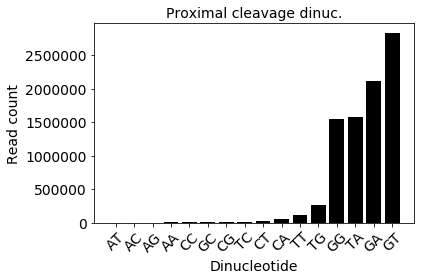

In [20]:
plot_cut_2mers(df_final, proximal_cuts_final)